In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

import numpy as np
import tensorflow as tf

from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input, Normalization, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import RootMeanSquaredError

import pprint


## **EDA**

In [34]:
data = pd.read_csv("retail_store_inventory.csv")

# Converting the Date column to "datetime objects", and making it the index of the df.
## For the time-series viz a few lines down.

data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')

data['Year'] = data.index.year
data['Month'] = data.index.month
data['Day'] = data.index.day
data['DayOfWeek'] = data.index.dayofweek  # Monday=0, Sunday=6

# Calculating the price difference between "our" product and competitors
data['Price_Difference'] = data['Price'] - data['Competitor Pricing']

data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 73100 entries, 2022-01-01 to 2024-01-01
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Store ID            73100 non-null  object 
 1   Product ID          73100 non-null  object 
 2   Category            73100 non-null  object 
 3   Region              73100 non-null  object 
 4   Inventory Level     73100 non-null  int64  
 5   Units Sold          73100 non-null  int64  
 6   Units Ordered       73100 non-null  int64  
 7   Demand Forecast     73100 non-null  float64
 8   Price               73100 non-null  float64
 9   Discount            73100 non-null  int64  
 10  Weather Condition   73100 non-null  object 
 11  Holiday/Promotion   73100 non-null  int64  
 12  Competitor Pricing  73100 non-null  float64
 13  Seasonality         73100 non-null  object 
 14  Year                73100 non-null  int32  
 15  Month               73100 non-null  

,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Holiday/Promotion,Competitor Pricing,Year,Month,Day,DayOfWeek,Price_Difference
count,73100.000000,73100.000000,73100.000000,73100.000000,73100.000000,73100.000000,73100.000000,73100.000000,73100.000000,73100.000000,73100.000000,73100.000000,73100.000000
mean,274.469877,136.464870,110.004473,141.494720,55.135108,10.009508,0.497305,55.146077,2022.502052,6.518468,15.700410,3.002736,-0.010969
std,129.949514,108.919406,52.277448,109.254076,26.021945,7.083746,0.499996,26.191408,0.502728,3.451564,8.807111,2.003429,2.888538
min,50.000000,0.000000,20.000000,-9.990000,10.000000,0.000000,0.000000,5.030000,2022.000000,1.000000,1.000000,0.000000,-5.000000
25%,162.000000,49.000000,65.000000,53.670000,32.650000,5.000000,0.000000,32.680000,2022.000000,4.000000,8.000000,1.000000,-2.530000
50%,273.000000,107.000000,110.000000,113.015000,55.050000,10.000000,0.000000,55.010000,2023.000000,7.000000,16.000000,3.000000,0.000000
75%,387.000000,203.000000,155.000000,208.052500,77.860000,15.000000,1.000000,77.820000,2023.000000,10.000000,23.000000,5.000000,2.500000
max,500.000000,499.000000,200.000000,518.550000,100.000000,20.000000,1.000000,104.940000,2024.000000,12.000000,31.000000,6.000000,5.000000


## **Data Preprocessing & Feature Engineering**

In [35]:
# Feature Engineering - Some pretty important metrics in Supply Chain
    ## Need to be careful with these, to prevent data leakage... be mindful of 
    ## what the target variable is, make sure to not use any engineered features
    ## that are derived from it...


data['Price_Discount_Ratio'] = data['Price'] / (data['Discount'] + 1)
# Captures price sensitivity and promotion impact.

data['Stock_to_Sales_Ratio'] = data['Inventory Level'] / data['Units Sold'].replace(0, np.nan)
# Indicates how much inventory is held, relative to sales. Indicates overstock or understock situations.

data['Sell_thru_Rate'] = data['Units Sold'] / (data['Units Sold'] + data['Inventory Level'])
# Percentage of inventory sold to customers

data['Backorder_Rate'] = (data['Units Ordered'] - data['Units Sold']) / data['Units Ordered'].replace(0, np.nan)
# Proportion of orders not fulfilled immediately. A sign of demand exceeding supply.

data['Order_Fulfillment_Rate'] = data['Units Sold'] / data['Units Ordered'].replace(0, np.nan)
# Inverse of Backorder Rate. How well you are meeting customer demand. 

data['Competitor_Price_Ratio'] = data['Price'] / data['Competitor Pricing'].replace(0, np.nan)
# Measures price positioning vs. competitors.

data['Demand_Forecast_Error'] = data['Units Sold'] - data['Demand Forecast']
# Difference between predicted and actual Demand.

In [36]:
# The Lagged features need to be properly sorted first before creating.
data = data.sort_values(by=['Product ID', 'Store ID', 'Year', 'Month', 'Day'])

data['Previous_Day_Units_Sold'] = data.groupby(['Product ID', 'Store ID'])['Units Sold'].shift(1)
# Lagged (by 1 day) Units Sold. "Yesterday's Sales". 

data['7Day_RollingAvg_Units_Sold'] = data.groupby(['Product ID', 'Store ID'])['Units Sold'].rolling(window=7, min_periods=1).mean().reset_index(level=[0,1], drop=True)
# 7-day rolling mean of Units Sold

data['7Day_RollingAvg_Inventory'] = data.groupby(['Product ID', 'Store ID'])['Inventory Level'].rolling(window=7, min_periods=1).mean().reset_index(level=[0, 1], drop=True)
# 7-day rolling average of Inventory Level

data['Inventory_Turnover_Rate'] = data['Units Sold'] / (data['7Day_RollingAvg_Inventory'] + 1e-6)
# A more stable Inventory Turnover rate, using the rolling average inventory...

In [37]:
data.info()
data.head(10)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 73100 entries, 2022-01-01 to 2024-01-01
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Store ID                    73100 non-null  object 
 1   Product ID                  73100 non-null  object 
 2   Category                    73100 non-null  object 
 3   Region                      73100 non-null  object 
 4   Inventory Level             73100 non-null  int64  
 5   Units Sold                  73100 non-null  int64  
 6   Units Ordered               73100 non-null  int64  
 7   Demand Forecast             73100 non-null  float64
 8   Price                       73100 non-null  float64
 9   Discount                    73100 non-null  int64  
 10  Weather Condition           73100 non-null  object 
 11  Holiday/Promotion           73100 non-null  int64  
 12  Competitor Pricing          73100 non-null  float64
 13  Seasonality   

,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,...,Stock_to_Sales_Ratio,Sell_thru_Rate,Backorder_Rate,Order_Fulfillment_Rate,Competitor_Price_Ratio,Demand_Forecast_Error,Previous_Day_Units_Sold,7Day_RollingAvg_Units_Sold,7Day_RollingAvg_Inventory,Inventory_Turnover_Rate
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-01,S001,P0001,Groceries,North,231,127,55,135.47,33.50,20,...,1.818898,0.354749,-1.309091,2.309091,1.128326,-8.47,NaN,127.000000,231.000000,0.549784
2022-01-02,S001,P0001,Groceries,West,116,81,104,92.94,27.95,10,...,1.432099,0.411168,0.221154,0.778846,0.904824,-11.94,127.0,104.000000,173.500000,0.466859
2022-01-03,S001,P0001,Electronics,West,154,5,189,5.36,62.70,20,...,30.800000,0.031447,0.973545,0.026455,1.076950,-0.36,81.0,71.000000,167.000000,0.029940
2022-01-04,S001,P0001,Groceries,South,85,58,193,52.87,77.88,15,...,1.465517,0.405594,0.699482,0.300518,1.024872,5.13,5.0,67.750000,146.500000,0.395904
2022-01-05,S001,P0001,Groceries,South,238,147,37,150.27,28.46,20,...,1.619048,0.381818,-2.972973,3.972973,0.968027,-3.27,58.0,83.600000,164.800000,0.891990
2022-01-06,S001,P0001,Electronics,East,198,37,155,39.09,91.05,5,...,5.351351,0.157447,0.761290,0.238710,1.042955,-2.09,147.0,75.833333,170.333333,0.217221
2022-01-07,S001,P0001,Furniture,North,195,107,106,117.92,53.99,10,...,1.822430,0.354305,-0.009434,1.009434,0.918197,-10.92,37.0,80.285714,173.857143,0.615448
2022-01-08,S001,P0001,Furniture,East,231,2,119,0.84,66.30,20,...,115.500000,0.008584,0.983193,0.016807,1.038859,1.16,107.0,62.428571,173.857143,0.011504
2022-01-09,S001,P0001,Electronics,South,373,350,178,352.24,41.72,0,...,1.065714,0.484094,-0.966292,1.966292,1.078594,-2.24,2.0,100.857143,210.571429,1.662144


In [38]:
# Dropping Rows with NaN in any of the Rolling Feature Columns
# dropna() with the 'subset' argument, makes sure we are ONLY 
# dropping rows that were in the initial rows for each group. 

columns_to_check = ['Previous_Day_Units_Sold', 
                    '7Day_RollingAvg_Units_Sold', 
                    '7Day_RollingAvg_Inventory', 
                    'Inventory_Turnover_Rate']

data.dropna(subset=columns_to_check, inplace=True)

print(f"Number of rows after dropping NaNs: {len(data)}")
data.head(10)

Number of rows after dropping NaNs: 73000


,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,...,Stock_to_Sales_Ratio,Sell_thru_Rate,Backorder_Rate,Order_Fulfillment_Rate,Competitor_Price_Ratio,Demand_Forecast_Error,Previous_Day_Units_Sold,7Day_RollingAvg_Units_Sold,7Day_RollingAvg_Inventory,Inventory_Turnover_Rate
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-02,S001,P0001,Groceries,West,116,81,104,92.94,27.95,10,...,1.432099,0.411168,0.221154,0.778846,0.904824,-11.94,127.0,104.000000,173.500000,0.466859
2022-01-03,S001,P0001,Electronics,West,154,5,189,5.36,62.70,20,...,30.800000,0.031447,0.973545,0.026455,1.076950,-0.36,81.0,71.000000,167.000000,0.029940
2022-01-04,S001,P0001,Groceries,South,85,58,193,52.87,77.88,15,...,1.465517,0.405594,0.699482,0.300518,1.024872,5.13,5.0,67.750000,146.500000,0.395904
2022-01-05,S001,P0001,Groceries,South,238,147,37,150.27,28.46,20,...,1.619048,0.381818,-2.972973,3.972973,0.968027,-3.27,58.0,83.600000,164.800000,0.891990
2022-01-06,S001,P0001,Electronics,East,198,37,155,39.09,91.05,5,...,5.351351,0.157447,0.761290,0.238710,1.042955,-2.09,147.0,75.833333,170.333333,0.217221
2022-01-07,S001,P0001,Furniture,North,195,107,106,117.92,53.99,10,...,1.822430,0.354305,-0.009434,1.009434,0.918197,-10.92,37.0,80.285714,173.857143,0.615448
2022-01-08,S001,P0001,Furniture,East,231,2,119,0.84,66.30,20,...,115.500000,0.008584,0.983193,0.016807,1.038859,1.16,107.0,62.428571,173.857143,0.011504
2022-01-09,S001,P0001,Electronics,South,373,350,178,352.24,41.72,0,...,1.065714,0.484094,-0.966292,1.966292,1.078594,-2.24,2.0,100.857143,210.571429,1.662144
2022-01-10,S001,P0001,Electronics,West,327,36,132,39.50,32.68,5,...,9.083333,0.099174,0.727273,0.272727,0.941515,-3.50,350.0,105.285714,235.285714,0.153005


In [39]:
# Categorical features (Remove the Target (y) from this each time, so we don't scale it)
categorical_features = [
    'Store ID', 'Product ID', 'Weather Condition', 'Holiday/Promotion',
    'Category', 'Region', 'Seasonality', 'Year', 'Month', 'Day', 'DayOfWeek'
]

# Numerical features (Remove the Target (y) from this each time, so we don't scale it)
numerical_features = [
    'Inventory Level', 'Price_Discount_Ratio', 'Competitor_Price_Ratio',
    'Previous_Day_Units_Sold', '7Day_RollingAvg_Units_Sold', '7Day_RollingAvg_Inventory'
]

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='drop'
)

In [40]:
target_variable = 'Units Sold'

# Example feature list (adjust based on your leakage assessment):
features = [ 'Store ID', 'Product ID', 'Weather Condition', 'Holiday/Promotion',
    'Category', 'Region', 'Seasonality', 'Year', 'Month', 'Day', 'DayOfWeek', 
    'Inventory Level', 'Price_Discount_Ratio', 'Competitor_Price_Ratio',
    'Previous_Day_Units_Sold', '7Day_RollingAvg_Units_Sold', '7Day_RollingAvg_Inventory'   
]

# Calculating Split Points
n = len(data)
n_train = int(n * 0.80)
n_val = int(n * 0.10)
# n_test = n - n_train - n_val
# test_size_pct is implicitly the 10% left after those two.

# Chronological Split
train_data = data.iloc[:n_train]
val_data = data.iloc[n_train : n_train + n_val]
test_data = data.iloc[n_train + n_val :]

# Separating all the Features and the Target for EACH set of data
X_train = train_data[features]
y_train = train_data[target_variable]

X_val = val_data[features]
y_val = val_data[target_variable]

X_test = test_data[features]
y_test = test_data[target_variable]

print(f"Training set shape: X={X_train.shape}, y={y_train.shape}")
print(f"Validation set shape: X={X_val.shape}, y={y_val.shape}")
print(f"Testing set shape: X={X_test.shape}, y={y_test.shape}")

Training set shape: X=(58400, 17), y=(58400,)
Validation set shape: X=(7300, 17), y=(7300,)
Testing set shape: X=(7300, 17), y=(7300,)


In [41]:
# Fiting the preprocessor on JUST the training data
X_train_processed = preprocessor.fit_transform(X_train)

# Transforming validation and test data
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)

# Converting the sparse matrix output (from One hot encoding) to a dense NumPy array
if hasattr(X_train_processed, "toarray"):
    X_train_processed = X_train_processed.toarray()
    X_val_processed = X_val_processed.toarray()
    X_test_processed = X_test_processed.toarray() 

print(f"Shape of processed X_train: {X_train_processed.shape}")
print(f"Shape of processed X_val: {X_val_processed.shape}")
print(f"Shape of processed X_test: {X_test_processed.shape}")

# Make sure y sets are NumPy arrays
y_train_np = y_train.values
y_val_np = y_val.values
y_test_np = y_test.values

Shape of processed X_train: (58400, 99)
Shape of processed X_val: (7300, 99)
Shape of processed X_test: (7300, 99)


**Base Model**

In [45]:
# Define/Compiling the Keras Model

tf.random.set_seed(42)

# Getting the number of features AFTER preprocessing
n_features_processed = X_train_processed.shape[1]

# Input Layer - shape needs to match the processed data...
input_layer = Input(shape=(n_features_processed,))

# Model
model = Sequential([
    input_layer,
    Dense(10, activation="relu"),   # Single Dense Layer w/ 10 Neurons and ReLU activation
    Dense(1)                        # Single Neuron Output Layer (for Regression)
])

# Compiling the model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse",
              optimizer=optimizer,
              metrics=[RootMeanSquaredError()])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 10)             │         1,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,011 (3.95 KB)

 Trainable params: 1,011 (3.95 KB)

 Non-trainable params: 0 (0.00 B)

In [46]:
# Defining Callbacks & Training the Model

early_stopping = EarlyStopping(monitor='val_loss', # Monitoring validation loss
                              patience=5,    # Stop training if no improvement after 5 epochs
                              restore_best_weights=True) # Keep the best model weights found

history = model.fit(
    X_train_processed, # Processed training features
    y_train_np,        # Training targets
    epochs=100,
    validation_data=(X_val_processed, y_val_np), # Use processed validation features
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 21767.4941 - root_mean_squared_error: 146.5666 - val_loss: 8017.7168 - val_root_mean_squared_error: 89.5417
Epoch 2/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 7579.8389 - root_mean_squared_error: 87.0469 - val_loss: 6645.8931 - val_root_mean_squared_error: 81.5223
Epoch 3/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 6617.7939 - root_mean_squared_error: 81.3464 - val_loss: 6466.6440 - val_root_mean_squared_error: 80.4154
Epoch 4/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 6468.2988 - root_mean_squared_error: 80.4227 - val_loss: 6416.7520 - val_root_mean_squared_error: 80.1046
Epoch 5/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 6416.2212 - root_mean_squared_error: 80.0984 - val_loss: 6359.0039 - val_root_mean_squared_error: 79.7434
Epoch 6/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 6347.9165 - root_mean_squared_error: 79.6710 - val_loss: 6294.1870 - val_root_mean_squared


Validation MSE (from evaluate): 5973.7461
Validation RMSE (from evaluate): 77.2900


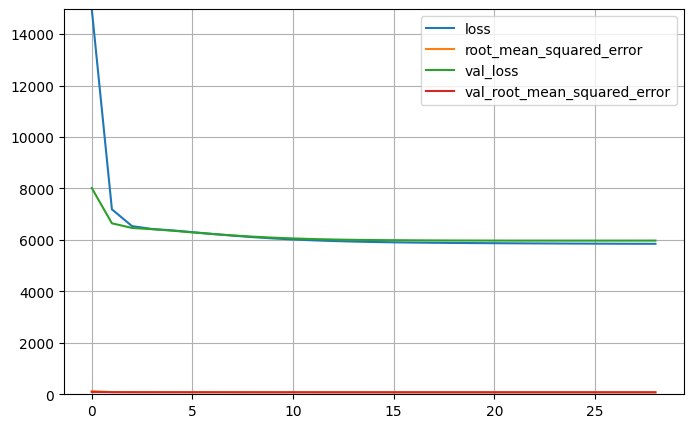

In [47]:
# Evaluating it's performance
val_loss, val_rmse = model.evaluate(X_val_processed, y_val_np, verbose=0)
print(f"\nValidation MSE (from evaluate): {val_loss:.4f}")
print(f"Validation RMSE (from evaluate): {val_rmse:.4f}")

# Ploting the learning curves
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, max(history.history['loss'] + history.history['val_loss']))
plt.show()

229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


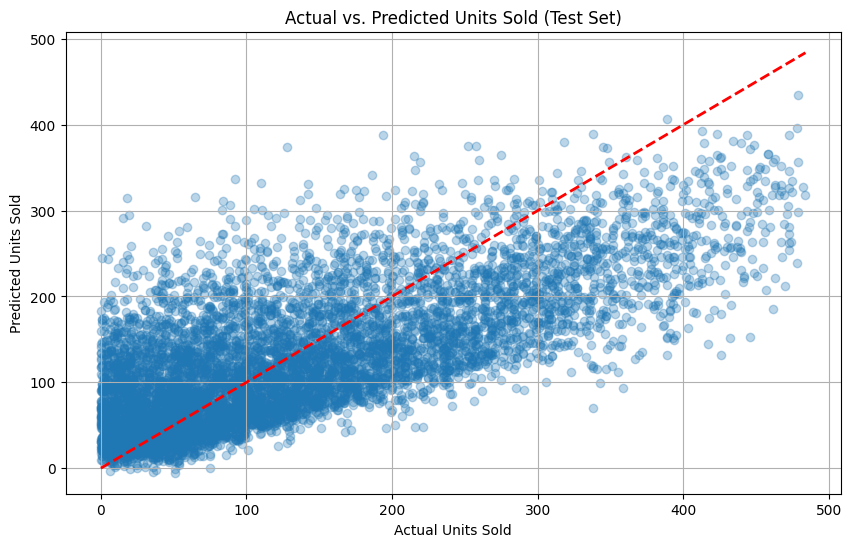

In [49]:
y_pred = model.predict(X_test_processed).flatten()
plt.figure(figsize=(10, 6))
plt.scatter(y_test_np, y_pred, alpha=0.3)
plt.plot([y_test_np.min(), y_test_np.max()], [y_test_np.min(), y_test_np.max()], '--r', linewidth=2)
plt.xlabel("Actual Units Sold")
plt.ylabel("Predicted Units Sold")
plt.title("Actual vs. Predicted Units Sold (Test Set)")
plt.grid(True)
plt.show()

*The RMSE from the simple base layer is already equivalent to the best random forest from the first model. Presumably it will get better with more layers. It converged quickly, so theres no obvious severe overfitting.*

**The baseline model only has 10 neurons in the hidden layer, while your input has 102 features after preprocessing... so I should probably try increasing the number of neurons.** 

### Model 1a - Dense Layer with 50 neurons and ReLU activation

Epoch 1/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 16430.8555 - root_mean_squared_error: 126.3058 - val_loss: 6576.4741 - val_root_mean_squared_error: 81.0955
Epoch 2/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 6582.4399 - root_mean_squared_error: 81.1290 - val_loss: 6503.2139 - val_root_mean_squared_error: 80.6425
Epoch 3/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 6523.3237 - root_mean_squared_error: 80.7638 - val_loss: 6440.1182 - val_root_mean_squared_error: 80.2503
Epoch 4/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 6433.6992 - root_mean_squared_error: 80.2070 - val_loss: 6326.8145 - val_root_mean_squared_error: 79.5413
Epoch 5/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 6313.7905 - root_mean_squared_error: 79.4562 - val_loss: 6235.6836 - val_root_mean_squared_error: 78.9663
Epoch 6/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 6223.4380 - root_mean_squared_error: 78.8858 - val_loss: 6174.6338 - val_root_mean_squared

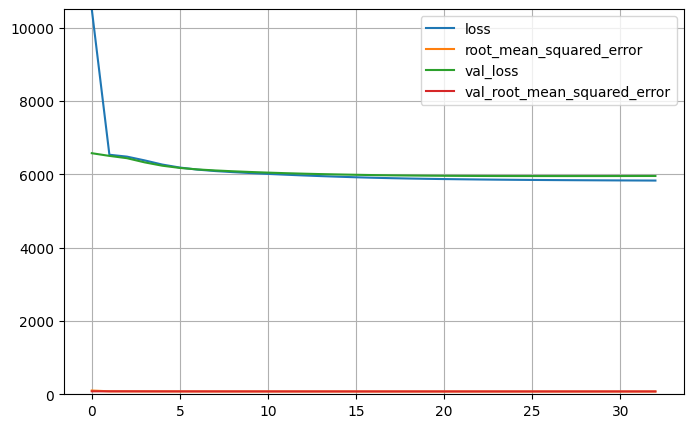

In [50]:
# Define/Compiling the Keras Model

tf.random.set_seed(42)

# Getting the number of features AFTER preprocessing
n_features_processed = X_train_processed.shape[1]

# Input Layer - shape needs to match the processed data...
input_layer = Input(shape=(n_features_processed,))

# Model
model = Sequential([
    input_layer,
    Dense(50, activation="relu"),   # Single Dense Layer w/ 50 Neurons and ReLU activation
    Dense(1)                        # Single Neuron Output Layer (for Regression)
])

# Compiling the model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse",
              optimizer=optimizer,
              metrics=[RootMeanSquaredError()])


# Defining Callbacks & Training the Model

early_stopping = EarlyStopping(monitor='val_loss', # Monitoring validation loss
                              patience=5,    # Stop training if no improvement after 5 epochs
                              restore_best_weights=True) # Keep the best model weights found

history = model.fit(
    X_train_processed, # Processed training features
    y_train_np,        # Training targets
    epochs=100,
    validation_data=(X_val_processed, y_val_np), # Use processed validation features
    callbacks=[early_stopping],
    verbose=1
)

# Evaluating it's performance
val_loss, val_rmse = model.evaluate(X_val_processed, y_val_np, verbose=0)
print(f"\nValidation MSE (from evaluate): {val_loss:.4f}")
print(f"Validation RMSE (from evaluate): {val_rmse:.4f}")

# Ploting the learning curves
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, max(history.history['loss'] + history.history['val_loss']))
plt.show()

### Model 1b - Dense Layer with 50 neurons, ReLU activation, Dropout(0.3)

Epoch 1/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 17254.3086 - root_mean_squared_error: 129.6663 - val_loss: 6706.7632 - val_root_mean_squared_error: 81.8948
Epoch 2/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 7075.5605 - root_mean_squared_error: 84.1124 - val_loss: 6450.2979 - val_root_mean_squared_error: 80.3137
Epoch 3/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 6847.5957 - root_mean_squared_error: 82.7457 - val_loss: 6330.0986 - val_root_mean_squared_error: 79.5619
Epoch 4/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 6653.0137 - root_mean_squared_error: 81.5633 - val_loss: 6223.9722 - val_root_mean_squared_error: 78.8922
Epoch 5/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 6588.6914 - root_mean_squared_error: 81.1683 - val_loss: 6152.0439 - val_root_mean_squared_error: 78.4350
Epoch 6/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 6537.2700 - root_mean_squared_error: 80.8513 - val_loss: 6112.2563 - val_root_mean_squared

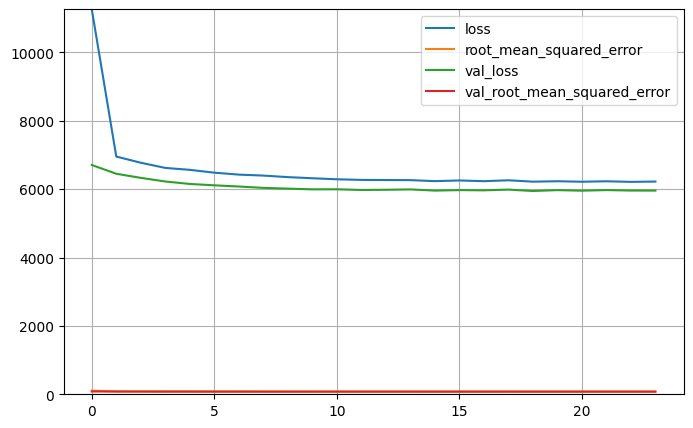

In [56]:
# Define/Compiling the Keras Model

tf.random.set_seed(42)

# Getting the number of features AFTER preprocessing
n_features_processed = X_train_processed.shape[1]

# Input Layer - shape needs to match the processed data...
input_layer = Input(shape=(n_features_processed,))

# Model
model = Sequential([
    input_layer,
    Dense(50, activation="relu"),   # Single Dense Layer w/ 50 Neurons and ReLU activation
    Dropout(0.3),
    Dense(1)                        # Single Neuron Output Layer (for Regression)
])

# Compiling the model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse",
              optimizer=optimizer,
              metrics=[RootMeanSquaredError()])


# Defining Callbacks & Training the Model

early_stopping = EarlyStopping(monitor='val_loss', # Monitoring validation loss
                              patience=5,    # Stop training if no improvement after 5 epochs
                              restore_best_weights=True) # Keep the best model weights found

history = model.fit(
    X_train_processed, # Processed training features
    y_train_np,        # Training targets
    epochs=100,
    validation_data=(X_val_processed, y_val_np), # Use processed validation features
    callbacks=[early_stopping],
    verbose=1
)

# Evaluating it's performance
val_loss, val_rmse = model.evaluate(X_val_processed, y_val_np, verbose=0)
print(f"\nValidation MSE (from evaluate): {val_loss:.4f}")
print(f"Validation RMSE (from evaluate): {val_rmse:.4f}")

# Ploting the learning curves
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, max(history.history['loss'] + history.history['val_loss']))
plt.show()

### Model 2a - Dense Layer with 100 neurons and ReLU activation

Epoch 1/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 14893.9160 - root_mean_squared_error: 120.0477 - val_loss: 6493.5386 - val_root_mean_squared_error: 80.5825
Epoch 2/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 6489.0737 - root_mean_squared_error: 80.5512 - val_loss: 6316.7842 - val_root_mean_squared_error: 79.4782
Epoch 3/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 6292.6699 - root_mean_squared_error: 79.3229 - val_loss: 6168.0503 - val_root_mean_squared_error: 78.5369
Epoch 4/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 6156.0811 - root_mean_squared_error: 78.4577 - val_loss: 6107.4751 - val_root_mean_squared_error: 78.1503
Epoch 5/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 6095.8745 - root_mean_squared_error: 78.0732 - val_loss: 6074.5361 - val_root_mean_squared_error: 77.9393
Epoch 6/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 6058.3594 - root_mean_squared_error: 77.8327 - val_loss: 6049.1211 - val_root_mean_squared

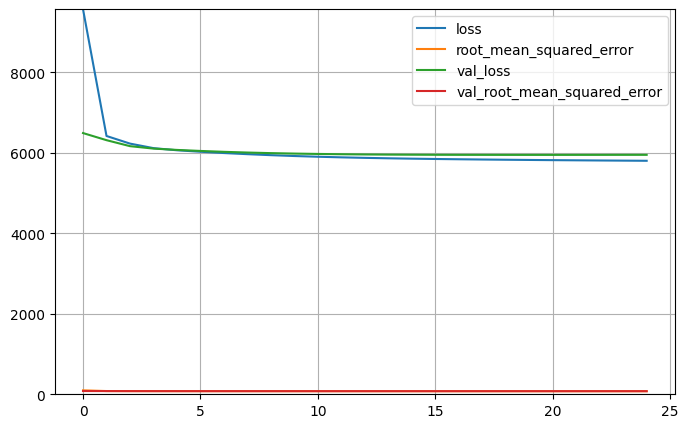

In [51]:
# Define/Compiling the Keras Model

tf.random.set_seed(42)

# Getting the number of features AFTER preprocessing
n_features_processed = X_train_processed.shape[1]

# Input Layer - shape needs to match the processed data...
input_layer = Input(shape=(n_features_processed,))

# Model
model = Sequential([
    input_layer,
    Dense(100, activation="relu"),   # Single Dense Layer w/ 100 Neurons and ReLU activation
    Dense(1)                        # Single Neuron Output Layer (for Regression)
])

# Compiling the model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse",
              optimizer=optimizer,
              metrics=[RootMeanSquaredError()])


# Defining Callbacks & Training the Model

early_stopping = EarlyStopping(monitor='val_loss', # Monitoring validation loss
                              patience=5,    # Stop training if no improvement after 5 epochs
                              restore_best_weights=True) # Keep the best model weights found

history = model.fit(
    X_train_processed, # Processed training features
    y_train_np,        # Training targets
    epochs=100,
    validation_data=(X_val_processed, y_val_np), # Use processed validation features
    callbacks=[early_stopping],
    verbose=1
)

# Evaluating it's performance
val_loss, val_rmse = model.evaluate(X_val_processed, y_val_np, verbose=0)
print(f"\nValidation MSE (from evaluate): {val_loss:.4f}")
print(f"Validation RMSE (from evaluate): {val_rmse:.4f}")

# Ploting the learning curves
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, max(history.history['loss'] + history.history['val_loss']))
plt.show()

### Model 2b - Dense Layer with 100 neurons, ReLU activation, Dropout(0.3)

Epoch 1/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 15501.2061 - root_mean_squared_error: 122.5682 - val_loss: 6530.1445 - val_root_mean_squared_error: 80.8093
Epoch 2/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 6794.7134 - root_mean_squared_error: 82.4269 - val_loss: 6371.0820 - val_root_mean_squared_error: 79.8191
Epoch 3/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 6551.8223 - root_mean_squared_error: 80.9389 - val_loss: 6180.7402 - val_root_mean_squared_error: 78.6177
Epoch 4/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 6408.9453 - root_mean_squared_error: 80.0525 - val_loss: 6098.9648 - val_root_mean_squared_error: 78.0959
Epoch 5/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 6276.8706 - root_mean_squared_error: 79.2240 - val_loss: 6030.5562 - val_root_mean_squared_error: 77.6567
Epoch 6/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 6222.8477 - root_mean_squared_error: 78.8814 - val_loss: 5992.7256 - val_root_mean_squared

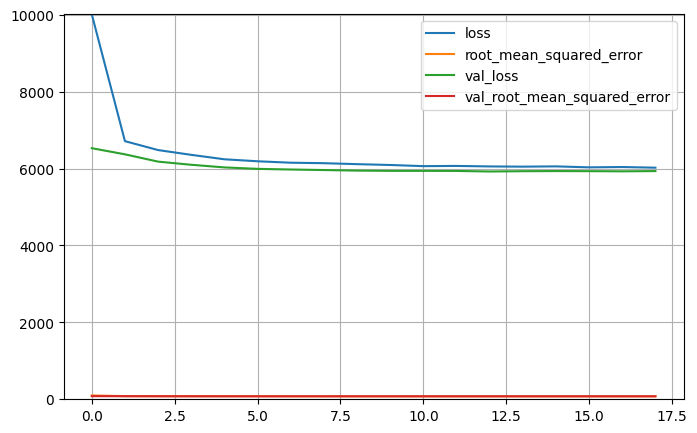

In [57]:
# Define/Compiling the Keras Model

tf.random.set_seed(42)

# Getting the number of features AFTER preprocessing
n_features_processed = X_train_processed.shape[1]

# Input Layer - shape needs to match the processed data...
input_layer = Input(shape=(n_features_processed,))

# Model
model = Sequential([
    input_layer,
    Dense(100, activation="relu"),   # Single Dense Layer w/ 100 Neurons and ReLU activation
    Dropout(0.3),
    Dense(1)                        # Single Neuron Output Layer (for Regression)
])

# Compiling the model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse",
              optimizer=optimizer,
              metrics=[RootMeanSquaredError()])


# Defining Callbacks & Training the Model

early_stopping = EarlyStopping(monitor='val_loss', # Monitoring validation loss
                              patience=5,    # Stop training if no improvement after 5 epochs
                              restore_best_weights=True) # Keep the best model weights found

history = model.fit(
    X_train_processed, # Processed training features
    y_train_np,        # Training targets
    epochs=100,
    validation_data=(X_val_processed, y_val_np), # Use processed validation features
    callbacks=[early_stopping],
    verbose=1
)

# Evaluating it's performance
val_loss, val_rmse = model.evaluate(X_val_processed, y_val_np, verbose=0)
print(f"\nValidation MSE (from evaluate): {val_loss:.4f}")
print(f"Validation RMSE (from evaluate): {val_rmse:.4f}")

# Ploting the learning curves
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, max(history.history['loss'] + history.history['val_loss']))
plt.show()

***Increasing the # of Neurons in the base layer didn't seem to improve it much at all, so now let's try deeper networks...***

### Model 3a - 2 Dense Layer's with 10 neurons each and ReLU activation

Epoch 1/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 16635.1523 - root_mean_squared_error: 126.9347 - val_loss: 6435.2476 - val_root_mean_squared_error: 80.2200
Epoch 2/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 6462.0684 - root_mean_squared_error: 80.3836 - val_loss: 6315.6719 - val_root_mean_squared_error: 79.4712
Epoch 3/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 6359.7378 - root_mean_squared_error: 79.7450 - val_loss: 6260.3628 - val_root_mean_squared_error: 79.1225
Epoch 4/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 6305.4883 - root_mean_squared_error: 79.4043 - val_loss: 6215.4712 - val_root_mean_squared_error: 78.8383
Epoch 5/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 6264.8486 - root_mean_squared_error: 79.1481 - val_loss: 6188.8208 - val_root_mean_squared_error: 78.6691
Epoch 6/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 6239.6997 - root_mean_squared_error: 78.9892 - val_loss: 6175.8818 - val_root_mean_squared

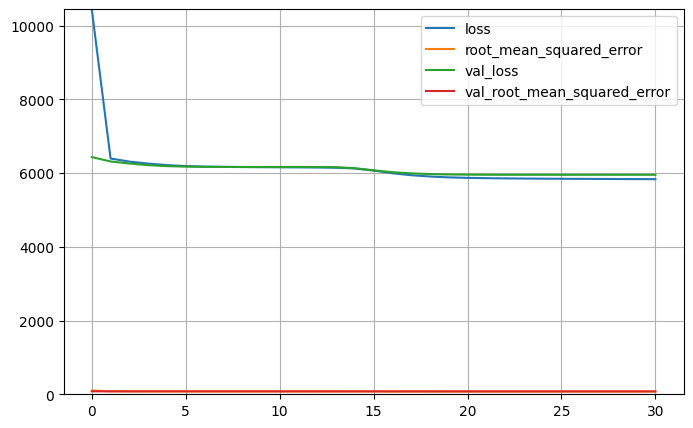

In [52]:
# Define/Compiling the Keras Model

tf.random.set_seed(42)

# Getting the number of features AFTER preprocessing
n_features_processed = X_train_processed.shape[1]

# Input Layer - shape needs to match the processed data...
input_layer = Input(shape=(n_features_processed,))

# Model
model = Sequential([
    input_layer,
    Dense(10, activation="relu"),   # 1st Dense Layer w/ 10 Neurons and ReLU activation
    Dense(10, activation="relu"),   # 2nd Dense Layer w/ 10 Neurons and ReLU activation
    Dense(1)                        # Single Neuron Output Layer (for Regression)
])

# Compiling the model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse",
              optimizer=optimizer,
              metrics=[RootMeanSquaredError()])


# Defining Callbacks & Training the Model

early_stopping = EarlyStopping(monitor='val_loss', # Monitoring validation loss
                              patience=5,    # Stop training if no improvement after 5 epochs
                              restore_best_weights=True) # Keep the best model weights found

history = model.fit(
    X_train_processed, # Processed training features
    y_train_np,        # Training targets
    epochs=100,
    validation_data=(X_val_processed, y_val_np), # Use processed validation features
    callbacks=[early_stopping],
    verbose=1
)

# Evaluating it's performance
val_loss, val_rmse = model.evaluate(X_val_processed, y_val_np, verbose=0)
print(f"\nValidation MSE (from evaluate): {val_loss:.4f}")
print(f"Validation RMSE (from evaluate): {val_rmse:.4f}")

# Ploting the learning curves
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, max(history.history['loss'] + history.history['val_loss']))
plt.show()

### Model 3b - 2 Dense Layer's with 10 neurons each, ReLU activation, Dropout(0.3)

Epoch 1/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 19365.3516 - root_mean_squared_error: 137.8948 - val_loss: 7341.3516 - val_root_mean_squared_error: 85.6817
Epoch 2/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 9918.0547 - root_mean_squared_error: 99.5843 - val_loss: 7092.9995 - val_root_mean_squared_error: 84.2199
Epoch 3/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 9514.4619 - root_mean_squared_error: 97.5392 - val_loss: 6924.2969 - val_root_mean_squared_error: 83.2124
Epoch 4/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 9405.1396 - root_mean_squared_error: 96.9756 - val_loss: 6780.5459 - val_root_mean_squared_error: 82.3441
Epoch 5/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 9246.4473 - root_mean_squared_error: 96.1524 - val_loss: 6772.5693 - val_root_mean_squared_error: 82.2956
Epoch 6/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 9059.6582 - root_mean_squared_error: 95.1789 - val_loss: 6626.0479 - val_root_mean_squared

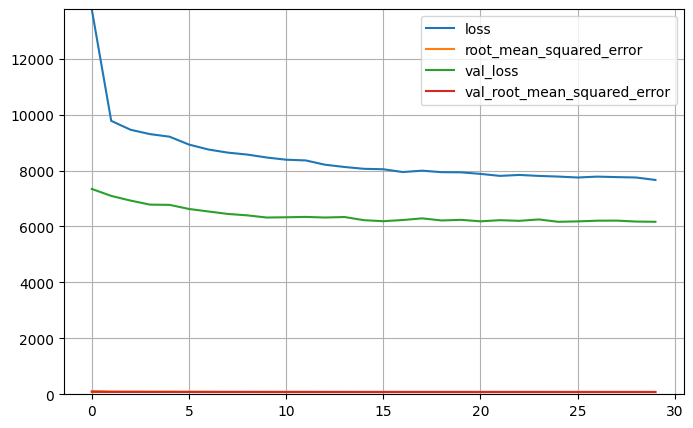

In [55]:
# Define/Compiling the Keras Model

tf.random.set_seed(42)

# Getting the number of features AFTER preprocessing
n_features_processed = X_train_processed.shape[1]

# Input Layer - shape needs to match the processed data...
input_layer = Input(shape=(n_features_processed,))

# Model
model = Sequential([
    input_layer,
    Dense(10, activation="relu"),   # 1st Dense Layer w/ 10 Neurons and ReLU activation
    Dropout(0.3),
    Dense(10, activation="relu"),   # 2nd Dense Layer w/ 10 Neurons and ReLU activation
    Dropout(0.3),
    Dense(1)                        # Single Neuron Output Layer (for Regression)
])

# Compiling the model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse",
              optimizer=optimizer,
              metrics=[RootMeanSquaredError()])


# Defining Callbacks & Training the Model

early_stopping = EarlyStopping(monitor='val_loss', # Monitoring validation loss
                              patience=5,    # Stop training if no improvement after 5 epochs
                              restore_best_weights=True) # Keep the best model weights found

history = model.fit(
    X_train_processed, # Processed training features
    y_train_np,        # Training targets
    epochs=100,
    validation_data=(X_val_processed, y_val_np), # Use processed validation features
    callbacks=[early_stopping],
    verbose=1
)

# Evaluating it's performance
val_loss, val_rmse = model.evaluate(X_val_processed, y_val_np, verbose=0)
print(f"\nValidation MSE (from evaluate): {val_loss:.4f}")
print(f"Validation RMSE (from evaluate): {val_rmse:.4f}")

# Ploting the learning curves
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, max(history.history['loss'] + history.history['val_loss']))
plt.show()

### Model 3c - 2 Dense Layer's (100->10 neurons), ReLU activation, Dropout(0.3)

Epoch 1/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 15414.0508 - root_mean_squared_error: 122.5190 - val_loss: 6624.9399 - val_root_mean_squared_error: 81.3937
Epoch 2/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 8736.3135 - root_mean_squared_error: 93.4645 - val_loss: 6457.9961 - val_root_mean_squared_error: 80.3617
Epoch 3/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 8607.8604 - root_mean_squared_error: 92.7725 - val_loss: 6413.5562 - val_root_mean_squared_error: 80.0847
Epoch 4/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 8414.1641 - root_mean_squared_error: 91.7249 - val_loss: 6291.8027 - val_root_mean_squared_error: 79.3209
Epoch 5/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 8519.7334 - root_mean_squared_error: 92.2996 - val_loss: 6165.7129 - val_root_mean_squared_error: 78.5221
Epoch 6/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 8332.4717 - root_mean_squared_error: 91.2785 - val_loss: 6301.8584 - val_root_mean_squared

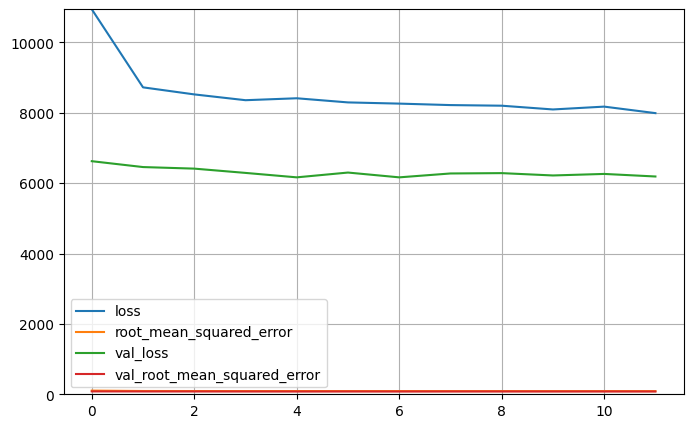

In [59]:
# Define/Compiling the Keras Model

tf.random.set_seed(42)

# Getting the number of features AFTER preprocessing
n_features_processed = X_train_processed.shape[1]

# Input Layer - shape needs to match the processed data...
input_layer = Input(shape=(n_features_processed,))

# Model
model = Sequential([
    input_layer,
    Dense(100, activation="relu"),   # 1st Dense Layer w/ 10 Neurons and ReLU activation
    Dropout(0.3),
    Dense(10, activation="relu"),   # 2nd Dense Layer w/ 10 Neurons and ReLU activation
    Dropout(0.3),
    Dense(1)                        # Single Neuron Output Layer (for Regression)
])

# Compiling the model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse",
              optimizer=optimizer,
              metrics=[RootMeanSquaredError()])


# Defining Callbacks & Training the Model

early_stopping = EarlyStopping(monitor='val_loss', # Monitoring validation loss
                              patience=5,    # Stop training if no improvement after 5 epochs
                              restore_best_weights=True) # Keep the best model weights found

history = model.fit(
    X_train_processed, # Processed training features
    y_train_np,        # Training targets
    epochs=100,
    validation_data=(X_val_processed, y_val_np), # Use processed validation features
    callbacks=[early_stopping],
    verbose=1
)

# Evaluating it's performance
val_loss, val_rmse = model.evaluate(X_val_processed, y_val_np, verbose=0)
print(f"\nValidation MSE (from evaluate): {val_loss:.4f}")
print(f"Validation RMSE (from evaluate): {val_rmse:.4f}")

# Ploting the learning curves
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, max(history.history['loss'] + history.history['val_loss']))
plt.show()

### Model 3d - 3 Dense Layer's (100->10->10 neurons), ReLU activation, Dropout(0.3)

Epoch 1/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 16894.5098 - root_mean_squared_error: 128.6307 - val_loss: 7013.2954 - val_root_mean_squared_error: 83.7454
Epoch 2/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 9656.4863 - root_mean_squared_error: 98.2623 - val_loss: 6657.3945 - val_root_mean_squared_error: 81.5929
Epoch 3/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 9304.8301 - root_mean_squared_error: 96.4584 - val_loss: 6528.9814 - val_root_mean_squared_error: 80.8021
Epoch 4/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 8750.9951 - root_mean_squared_error: 93.5424 - val_loss: 6415.7866 - val_root_mean_squared_error: 80.0986
Epoch 5/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 8757.5176 - root_mean_squared_error: 93.5797 - val_loss: 6378.2852 - val_root_mean_squared_error: 79.8642
Epoch 6/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 8524.0068 - root_mean_squared_error: 92.3236 - val_loss: 6285.0879 - val_root_mean_squared

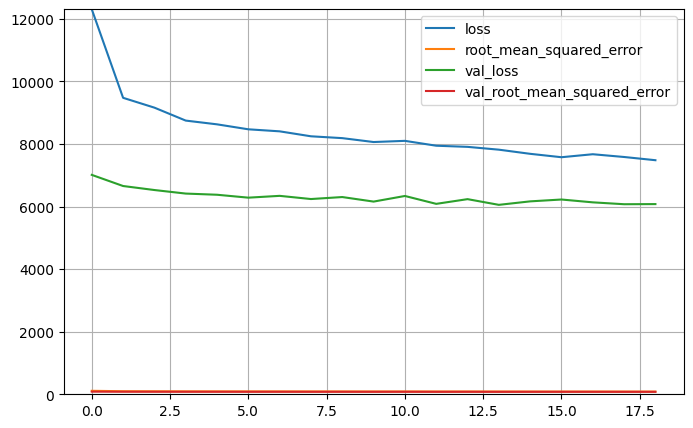

In [60]:
# Define/Compiling the Keras Model

tf.random.set_seed(42)

# Getting the number of features AFTER preprocessing
n_features_processed = X_train_processed.shape[1]

# Input Layer - shape needs to match the processed data...
input_layer = Input(shape=(n_features_processed,))

# Model
model = Sequential([
    input_layer,
    Dense(100, activation="relu"),   # 1st Dense Layer w/ 10 Neurons and ReLU activation
    Dropout(0.3),
    Dense(10, activation="relu"),   # 2nd Dense Layer w/ 10 Neurons and ReLU activation
    Dropout(0.3),
    Dense(10, activation="relu"),   # 3rd Dense Layer w/ 10 Neurons and ReLU activation
    Dropout(0.3),
    Dense(1)                        # Single Neuron Output Layer (for Regression)
])

# Compiling the model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse",
              optimizer=optimizer,
              metrics=[RootMeanSquaredError()])


# Defining Callbacks & Training the Model

early_stopping = EarlyStopping(monitor='val_loss', # Monitoring validation loss
                              patience=5,    # Stop training if no improvement after 5 epochs
                              restore_best_weights=True) # Keep the best model weights found

history = model.fit(
    X_train_processed, # Processed training features
    y_train_np,        # Training targets
    epochs=100,
    validation_data=(X_val_processed, y_val_np), # Use processed validation features
    callbacks=[early_stopping],
    verbose=1
)

# Evaluating it's performance
val_loss, val_rmse = model.evaluate(X_val_processed, y_val_np, verbose=0)
print(f"\nValidation MSE (from evaluate): {val_loss:.4f}")
print(f"Validation RMSE (from evaluate): {val_rmse:.4f}")

# Ploting the learning curves
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, max(history.history['loss'] + history.history['val_loss']))
plt.show()

After experimenting with wider and deeper networks, with and without dropout, the best combo I've found is: **Model 2b Dense Layer with 100 neurons, ReLU activation, Dropout(0.3)**

Scores:
        Validation **MSE: 5924.1602**
        Validation **RMSE: 76.9686**

Let's make that our new "Base" model, and experiment with Hyperparameters: ***Dropout Rate, Learning Rate, Activation Function and Batch Size.***

*(Going Deeper and Wider aren't having much of an impact so far, so we should try tuning hyperparameters)*

# ~Mannual Hyperparameter Tuning~

### NEW Base Model: 1x100 Neurons, ReLU, Dropout(0.3)

Epoch 1/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 15596.0205 - root_mean_squared_error: 122.9324 - val_loss: 6541.7549 - val_root_mean_squared_error: 80.8811
Epoch 2/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 6803.7236 - root_mean_squared_error: 82.4798 - val_loss: 6339.9854 - val_root_mean_squared_error: 79.6240
Epoch 3/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 6555.5581 - root_mean_squared_error: 80.9616 - val_loss: 6188.2656 - val_root_mean_squared_error: 78.6655
Epoch 4/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 6409.5264 - root_mean_squared_error: 80.0569 - val_loss: 6097.6294 - val_root_mean_squared_error: 78.0873
Epoch 5/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 6299.9131 - root_mean_squared_error: 79.3697 - val_loss: 6057.9595 - val_root_mean_squared_error: 77.8329
Epoch 6/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 6267.9458 - root_mean_squared_error: 79.1676 - val_loss: 6010.2114 - val_root_mean_squared

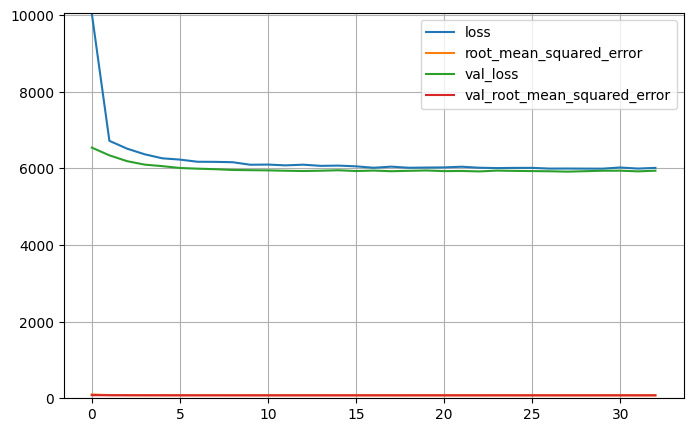

In [61]:
# Define/Compiling the Keras Model

tf.random.set_seed(42)

# Getting the number of features AFTER preprocessing
n_features_processed = X_train_processed.shape[1]

# Input Layer - shape needs to match the processed data...
input_layer = Input(shape=(n_features_processed,))

# Best Model so far...
model = Sequential([
    input_layer,
    Dense(100, activation="relu"),   # Single Dense Layer w/ 100 Neurons and ReLU activation
    Dropout(0.3),
    Dense(1)                        # Single Neuron Output Layer (for Regression)
])

# Compiling the model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse",
              optimizer=optimizer,
              metrics=[RootMeanSquaredError()])


# Defining Callbacks & Training the Model

early_stopping = EarlyStopping(monitor='val_loss', # Monitoring validation loss
                              patience=5,    # Stop training if no improvement after 5 epochs
                              restore_best_weights=True) # Keep the best model weights found

history = model.fit(
    X_train_processed, # Processed training features
    y_train_np,        # Training targets
    epochs=100,
    validation_data=(X_val_processed, y_val_np), # Use processed validation features
    callbacks=[early_stopping],
    verbose=1
)

# Evaluating it's performance
val_loss, val_rmse = model.evaluate(X_val_processed, y_val_np, verbose=0)
print(f"\nValidation MSE (from evaluate): {val_loss:.4f}")
print(f"Validation RMSE (from evaluate): {val_rmse:.4f}")

# Ploting the learning curves
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, max(history.history['loss'] + history.history['val_loss']))
plt.show()

### Trial 1.1 - Dropout(0.2)

Epoch 1/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 15390.3867 - root_mean_squared_error: 122.0550 - val_loss: 6502.0889 - val_root_mean_squared_error: 80.6355
Epoch 2/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 6651.9155 - root_mean_squared_error: 81.5557 - val_loss: 6322.6182 - val_root_mean_squared_error: 79.5149
Epoch 3/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 6429.0674 - root_mean_squared_error: 80.1786 - val_loss: 6124.5957 - val_root_mean_squared_error: 78.2598
Epoch 4/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 6267.9155 - root_mean_squared_error: 79.1671 - val_loss: 6054.4478 - val_root_mean_squared_error: 77.8103
Epoch 5/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 6189.0771 - root_mean_squared_error: 78.6681 - val_loss: 6011.6133 - val_root_mean_squared_error: 77.5346
Epoch 6/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 6138.2290 - root_mean_squared_error: 78.3443 - val_loss: 5983.3154 - val_root_mean_squared

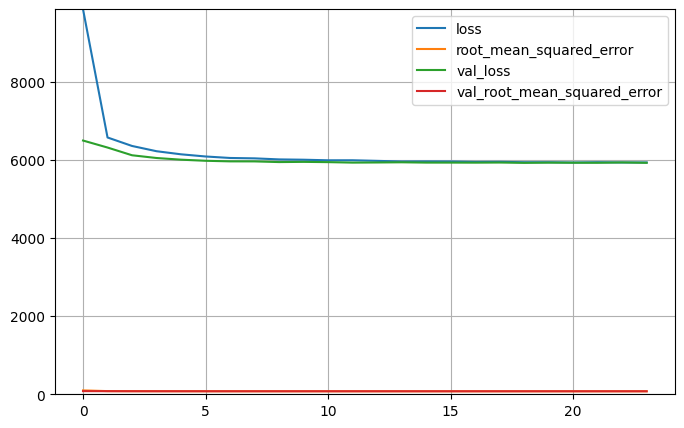

In [62]:
# Define/Compiling the Keras Model

tf.random.set_seed(42)

# Getting the number of features AFTER preprocessing
n_features_processed = X_train_processed.shape[1]

# Input Layer - shape needs to match the processed data...
input_layer = Input(shape=(n_features_processed,))

# Best Model so far...
model = Sequential([
    input_layer,
    Dense(100, activation="relu"),   # Single Dense Layer w/ 100 Neurons and ReLU activation
    Dropout(0.2),
    Dense(1)                        # Single Neuron Output Layer (for Regression)
])

# Compiling the model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse",
              optimizer=optimizer,
              metrics=[RootMeanSquaredError()])


# Defining Callbacks & Training the Model

early_stopping = EarlyStopping(monitor='val_loss', # Monitoring validation loss
                              patience=5,    # Stop training if no improvement after 5 epochs
                              restore_best_weights=True) # Keep the best model weights found

history = model.fit(
    X_train_processed, # Processed training features
    y_train_np,        # Training targets
    epochs=100,
    validation_data=(X_val_processed, y_val_np), # Use processed validation features
    callbacks=[early_stopping],
    verbose=1
)

# Evaluating it's performance
val_loss, val_rmse = model.evaluate(X_val_processed, y_val_np, verbose=0)
print(f"\nValidation MSE (from evaluate): {val_loss:.4f}")
print(f"Validation RMSE (from evaluate): {val_rmse:.4f}")

# Ploting the learning curves
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, max(history.history['loss'] + history.history['val_loss']))
plt.show()

### Trial 1.2 - Dropout(0.4)

Epoch 1/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 15348.5264 - root_mean_squared_error: 121.9552 - val_loss: 6520.2842 - val_root_mean_squared_error: 80.7483
Epoch 2/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 6793.6504 - root_mean_squared_error: 82.4200 - val_loss: 6331.4824 - val_root_mean_squared_error: 79.5706
Epoch 3/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 6589.1279 - root_mean_squared_error: 81.1712 - val_loss: 6171.5513 - val_root_mean_squared_error: 78.5592
Epoch 4/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 6464.7778 - root_mean_squared_error: 80.4018 - val_loss: 6091.5747 - val_root_mean_squared_error: 78.0485
Epoch 5/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 6365.9067 - root_mean_squared_error: 79.7844 - val_loss: 6024.8467 - val_root_mean_squared_error: 77.6199
Epoch 6/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 6314.6768 - root_mean_squared_error: 79.4629 - val_loss: 5996.3569 - val_root_mean_squared

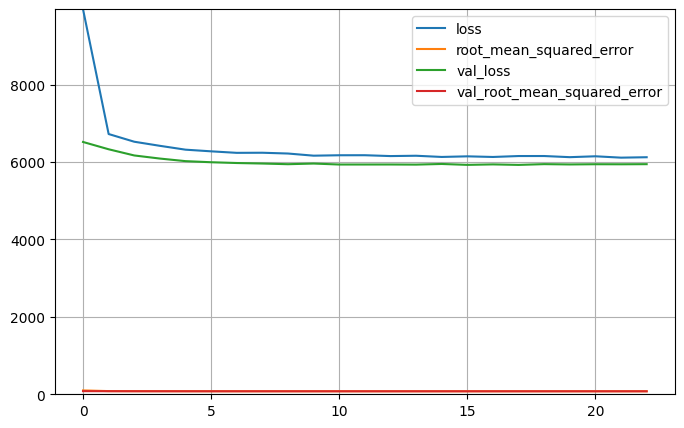

In [63]:
# Define/Compiling the Keras Model

tf.random.set_seed(42)

# Getting the number of features AFTER preprocessing
n_features_processed = X_train_processed.shape[1]

# Input Layer - shape needs to match the processed data...
input_layer = Input(shape=(n_features_processed,))

# Best Model so far...
model = Sequential([
    input_layer,
    Dense(100, activation="relu"),   # Single Dense Layer w/ 100 Neurons and ReLU activation
    Dropout(0.4),
    Dense(1)                        # Single Neuron Output Layer (for Regression)
])

# Compiling the model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse",
              optimizer=optimizer,
              metrics=[RootMeanSquaredError()])


# Defining Callbacks & Training the Model

early_stopping = EarlyStopping(monitor='val_loss', # Monitoring validation loss
                              patience=5,    # Stop training if no improvement after 5 epochs
                              restore_best_weights=True) # Keep the best model weights found

history = model.fit(
    X_train_processed, # Processed training features
    y_train_np,        # Training targets
    epochs=100,
    validation_data=(X_val_processed, y_val_np), # Use processed validation features
    callbacks=[early_stopping],
    verbose=1
)

# Evaluating it's performance
val_loss, val_rmse = model.evaluate(X_val_processed, y_val_np, verbose=0)
print(f"\nValidation MSE (from evaluate): {val_loss:.4f}")
print(f"Validation RMSE (from evaluate): {val_rmse:.4f}")

# Ploting the learning curves
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, max(history.history['loss'] + history.history['val_loss']))
plt.show()

### Trial 1.3 - Dropout(0.5)

Epoch 1/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 16009.3574 - root_mean_squared_error: 124.6866 - val_loss: 6579.2695 - val_root_mean_squared_error: 81.1127
Epoch 2/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 6989.6636 - root_mean_squared_error: 83.6012 - val_loss: 6382.4858 - val_root_mean_squared_error: 79.8905
Epoch 3/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 6756.2798 - root_mean_squared_error: 82.1935 - val_loss: 6227.5679 - val_root_mean_squared_error: 78.9149
Epoch 4/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 6667.5151 - root_mean_squared_error: 81.6503 - val_loss: 6153.8047 - val_root_mean_squared_error: 78.4462
Epoch 5/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 6588.8096 - root_mean_squared_error: 81.1695 - val_loss: 6085.8706 - val_root_mean_squared_error: 78.0120
Epoch 6/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 6528.4258 - root_mean_squared_error: 80.7972 - val_loss: 6037.2212 - val_root_mean_squared

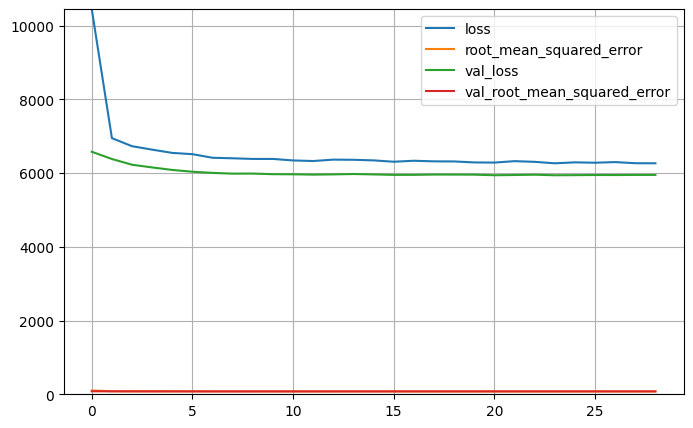

In [64]:
# Define/Compiling the Keras Model

tf.random.set_seed(42)

# Getting the number of features AFTER preprocessing
n_features_processed = X_train_processed.shape[1]

# Input Layer - shape needs to match the processed data...
input_layer = Input(shape=(n_features_processed,))

# Best Model so far...
model = Sequential([
    input_layer,
    Dense(100, activation="relu"),   # Single Dense Layer w/ 100 Neurons and ReLU activation
    Dropout(0.5),
    Dense(1)                        # Single Neuron Output Layer (for Regression)
])

# Compiling the model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse",
              optimizer=optimizer,
              metrics=[RootMeanSquaredError()])


# Defining Callbacks & Training the Model

early_stopping = EarlyStopping(monitor='val_loss', # Monitoring validation loss
                              patience=5,    # Stop training if no improvement after 5 epochs
                              restore_best_weights=True) # Keep the best model weights found

history = model.fit(
    X_train_processed, # Processed training features
    y_train_np,        # Training targets
    epochs=100,
    validation_data=(X_val_processed, y_val_np), # Use processed validation features
    callbacks=[early_stopping],
    verbose=1
)

# Evaluating it's performance
val_loss, val_rmse = model.evaluate(X_val_processed, y_val_np, verbose=0)
print(f"\nValidation MSE (from evaluate): {val_loss:.4f}")
print(f"Validation RMSE (from evaluate): {val_rmse:.4f}")

# Ploting the learning curves
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, max(history.history['loss'] + history.history['val_loss']))
plt.show()

(Trial 1.1, Dropout(0.2)) RMSE: 77.0079

(NEW Base, Dropout(0.3))  RMSE: 76.9046  ***<--- BEST SCORE  (Move forward with Dropout Rate = 0.3)***

(Trial 1.2, Dropout(0.4)) RMSE: 76.9910

(Trial 1.3, Dropout(0.5)) RMSE: 77.0848

### Trial 2.1 - Learning Rate = 3e-4 (0.0003), Dropout(0.3)

Epoch 1/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 23264.1523 - root_mean_squared_error: 151.7955 - val_loss: 8689.1504 - val_root_mean_squared_error: 93.2156
Epoch 2/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 8331.8770 - root_mean_squared_error: 91.2602 - val_loss: 6907.3779 - val_root_mean_squared_error: 83.1106
Epoch 3/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 7049.4385 - root_mean_squared_error: 83.9566 - val_loss: 6598.6699 - val_root_mean_squared_error: 81.2322
Epoch 4/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 6820.4053 - root_mean_squared_error: 82.5822 - val_loss: 6528.1431 - val_root_mean_squared_error: 80.7969
Epoch 5/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 6759.5146 - root_mean_squared_error: 82.2132 - val_loss: 6493.4277 - val_root_mean_squared_error: 80.5818
Epoch 6/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 6707.0210 - root_mean_squared_error: 81.8930 - val_loss: 6437.0859 - val_root_mean_squared

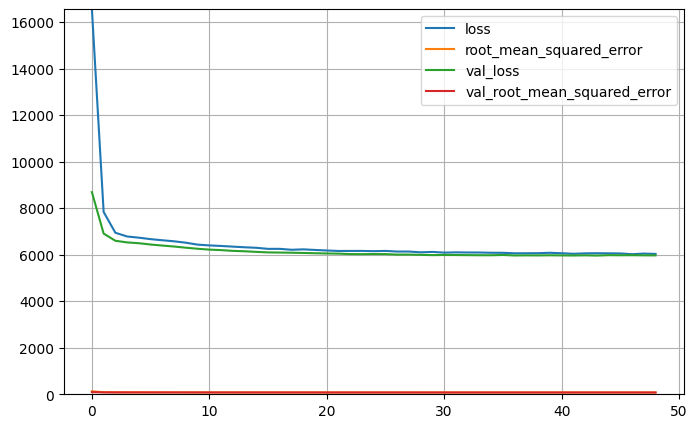

In [66]:
# Define/Compiling the Keras Model

tf.random.set_seed(42)

# Getting the number of features AFTER preprocessing
n_features_processed = X_train_processed.shape[1]

# Input Layer - shape needs to match the processed data...
input_layer = Input(shape=(n_features_processed,))

# Best Model so far...
model = Sequential([
    input_layer,
    Dense(100, activation="relu"),   # Single Dense Layer w/ 100 Neurons and ReLU activation
    Dropout(0.3),
    Dense(1)                        # Single Neuron Output Layer (for Regression)
])

# Compiling the model
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4)
model.compile(loss="mse",
              optimizer=optimizer,
              metrics=[RootMeanSquaredError()])


# Defining Callbacks & Training the Model

early_stopping = EarlyStopping(monitor='val_loss', # Monitoring validation loss
                              patience=5,    # Stop training if no improvement after 5 epochs
                              restore_best_weights=True) # Keep the best model weights found

history = model.fit(
    X_train_processed, # Processed training features
    y_train_np,        # Training targets
    epochs=100,
    validation_data=(X_val_processed, y_val_np), # Use processed validation features
    callbacks=[early_stopping],
    verbose=1
)

# Evaluating it's performance
val_loss, val_rmse = model.evaluate(X_val_processed, y_val_np, verbose=0)
print(f"\nValidation MSE (from evaluate): {val_loss:.4f}")
print(f"Validation RMSE (from evaluate): {val_rmse:.4f}")

# Ploting the learning curves
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, max(history.history['loss'] + history.history['val_loss']))
plt.show()

### Trial 2.2 - Learning Rate = 1e-4 (0.0001), Dropout(0.3)

Epoch 1/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 28347.1855 - root_mean_squared_error: 168.3135 - val_loss: 18965.5371 - val_root_mean_squared_error: 137.7154
Epoch 2/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 15617.9951 - root_mean_squared_error: 124.8254 - val_loss: 10131.6172 - val_root_mean_squared_error: 100.6559
Epoch 3/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 9538.5820 - root_mean_squared_error: 97.6583 - val_loss: 8483.0020 - val_root_mean_squared_error: 92.1032
Epoch 4/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 8491.1846 - root_mean_squared_error: 92.1446 - val_loss: 7718.4521 - val_root_mean_squared_error: 87.8547
Epoch 5/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 7816.9248 - root_mean_squared_error: 88.4098 - val_loss: 7191.0361 - val_root_mean_squared_error: 84.8000
Epoch 6/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 7310.2783 - root_mean_squared_error: 85.4967 - val_loss: 6885.8213 - val_root_mean_s

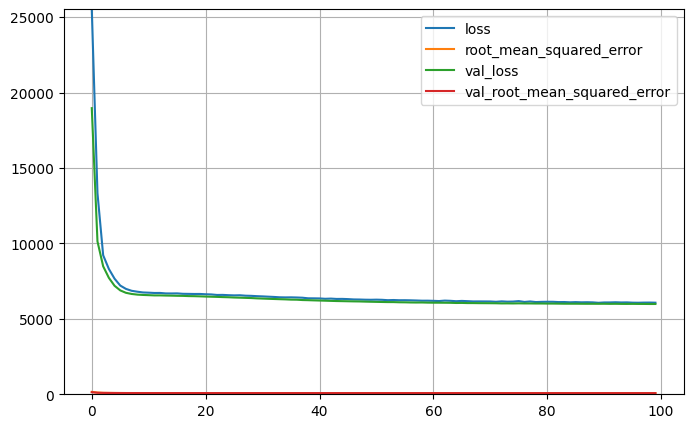

In [67]:
# Define/Compiling the Keras Model

tf.random.set_seed(42)

# Getting the number of features AFTER preprocessing
n_features_processed = X_train_processed.shape[1]

# Input Layer - shape needs to match the processed data...
input_layer = Input(shape=(n_features_processed,))

# Best Model so far...
model = Sequential([
    input_layer,
    Dense(100, activation="relu"),   # Single Dense Layer w/ 100 Neurons and ReLU activation
    Dropout(0.3),
    Dense(1)                        # Single Neuron Output Layer (for Regression)
])

# Compiling the model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(loss="mse",
              optimizer=optimizer,
              metrics=[RootMeanSquaredError()])


# Defining Callbacks & Training the Model

early_stopping = EarlyStopping(monitor='val_loss', # Monitoring validation loss
                              patience=5,    # Stop training if no improvement after 5 epochs
                              restore_best_weights=True) # Keep the best model weights found

history = model.fit(
    X_train_processed, # Processed training features
    y_train_np,        # Training targets
    epochs=100,
    validation_data=(X_val_processed, y_val_np), # Use processed validation features
    callbacks=[early_stopping],
    verbose=1
)

# Evaluating it's performance
val_loss, val_rmse = model.evaluate(X_val_processed, y_val_np, verbose=0)
print(f"\nValidation MSE (from evaluate): {val_loss:.4f}")
print(f"Validation RMSE (from evaluate): {val_rmse:.4f}")

# Ploting the learning curves
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, max(history.history['loss'] + history.history['val_loss']))
plt.show()

*...keeping the best dropout rate = 0.3*

(NEW Base, Learning Rate = 1e-3 (0.001))  RMSE: 76.9046 ***<--- BEST SCORE  (Move forward with Learning Rate = 1e-3)***

(Trial 2.1, Learning Rate = 3e-4 (0.0003)) RMSE: 77.2176

(Trial 2.2, Learning Rate = 1e-4 (0.0001)) RMSE: 77.3546

### Trial 3 - tanh activation

Epoch 1/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 20135.7773 - root_mean_squared_error: 141.2029 - val_loss: 9097.1494 - val_root_mean_squared_error: 95.3790
Epoch 2/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 8467.6904 - root_mean_squared_error: 91.9981 - val_loss: 6876.5977 - val_root_mean_squared_error: 82.9253
Epoch 3/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 6857.3716 - root_mean_squared_error: 82.8037 - val_loss: 6253.7622 - val_root_mean_squared_error: 79.0807
Epoch 4/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 6441.2021 - root_mean_squared_error: 80.2543 - val_loss: 6090.4707 - val_root_mean_squared_error: 78.0415
Epoch 5/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 6368.0684 - root_mean_squared_error: 79.7975 - val_loss: 6037.9824 - val_root_mean_squared_error: 77.7045
Epoch 6/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 6297.0977 - root_mean_squared_error: 79.3518 - val_loss: 6017.2798 - val_root_mean_squared

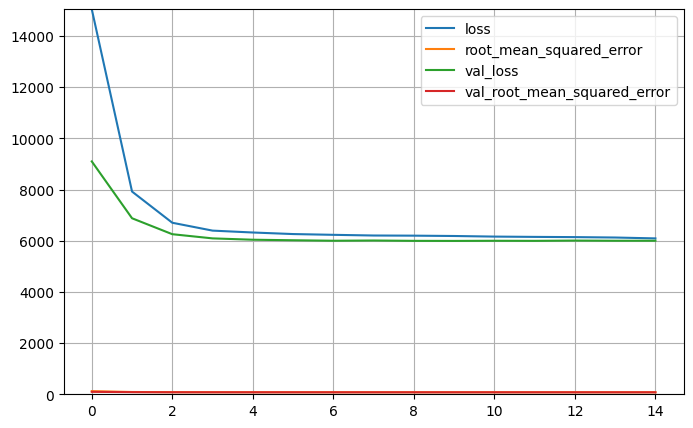

In [68]:
# Define/Compiling the Keras Model

tf.random.set_seed(42)

# Getting the number of features AFTER preprocessing
n_features_processed = X_train_processed.shape[1]

# Input Layer - shape needs to match the processed data...
input_layer = Input(shape=(n_features_processed,))

# Best Model so far...
model = Sequential([
    input_layer,
    Dense(100, activation="tanh"),   # Single Dense Layer w/ 100 Neurons and tanh activation
    Dropout(0.3),
    Dense(1)                        # Single Neuron Output Layer (for Regression)
])

# Compiling the model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse",
              optimizer=optimizer,
              metrics=[RootMeanSquaredError()])


# Defining Callbacks & Training the Model

early_stopping = EarlyStopping(monitor='val_loss', # Monitoring validation loss
                              patience=5,    # Stop training if no improvement after 5 epochs
                              restore_best_weights=True) # Keep the best model weights found

history = model.fit(
    X_train_processed, # Processed training features
    y_train_np,        # Training targets
    epochs=100,
    validation_data=(X_val_processed, y_val_np), # Use processed validation features
    callbacks=[early_stopping],
    verbose=1
)

# Evaluating it's performance
val_loss, val_rmse = model.evaluate(X_val_processed, y_val_np, verbose=0)
print(f"\nValidation MSE (from evaluate): {val_loss:.4f}")
print(f"Validation RMSE (from evaluate): {val_rmse:.4f}")

# Ploting the learning curves
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, max(history.history['loss'] + history.history['val_loss']))
plt.show()

*...keeping the best dropout rate = 0.3, and best learning rate = 1e-3*

(NEW Base, ReLU Activation)  RMSE: 76.9046 ***<--- BEST SCORE  (Move forward with ReLU Activation)***

(Trial 3, tanh Activation) RMSE: 77.4035

### *So... none of those improved the RMSE. Lol.*

## ~More mannual tuning, with the same current best model~

### Trial 4a - Batch Normalization + Activation + Dropout

Epoch 1/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 19063.3633 - root_mean_squared_error: 136.5172 - val_loss: 6269.2734 - val_root_mean_squared_error: 79.1787
Epoch 2/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 6685.4048 - root_mean_squared_error: 81.7612 - val_loss: 6228.4727 - val_root_mean_squared_error: 78.9207
Epoch 3/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 6618.9727 - root_mean_squared_error: 81.3551 - val_loss: 6220.8516 - val_root_mean_squared_error: 78.8724
Epoch 4/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 6594.4819 - root_mean_squared_error: 81.2026 - val_loss: 6213.6724 - val_root_mean_squared_error: 78.8269
Epoch 5/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 6570.1250 - root_mean_squared_error: 81.0536 - val_loss: 6201.3442 - val_root_mean_squared_error: 78.7486
Epoch 6/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 6541.5732 - root_mean_squared_error: 80.8774 - val_loss: 6207.4067 - val_root_mean_squared

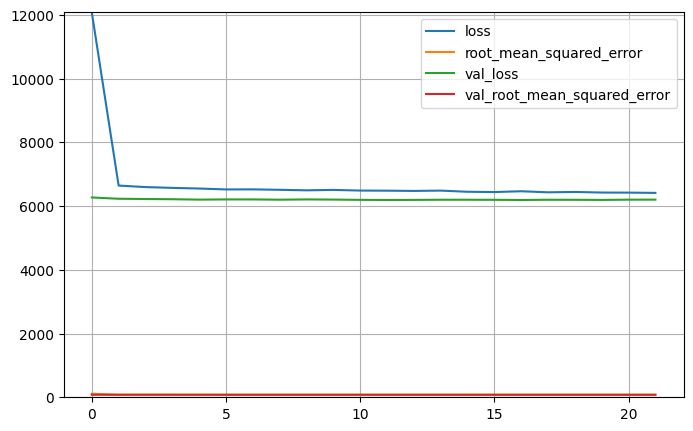

In [ ]:
# Define/Compiling the Keras Model

tf.random.set_seed(42)

# Getting the number of features AFTER preprocessing
n_features_processed = X_train_processed.shape[1]

# Input Layer - shape needs to match the processed data...
input_layer = Input(shape=(n_features_processed,))

# Model
model = Sequential([
    input_layer,
    Dense(100, use_bias=False),   # Single Dense Layer w/ 100 Neurons. # Aparently it's good to turn bias off if you're going to use Batch Normalization right after...
    BatchNormalization(),      # Batch Normalization after the 1st layer
    Activation("relu"),     # Now applying activation after Batch Normalization
    Dropout(0.3),
    Dense(1)            # Single Neuron Output Layer (for Regression)
])

# Compiling the model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse",
              optimizer=optimizer,
              metrics=[RootMeanSquaredError()])


# Defining Callbacks & Training the Model

early_stopping = EarlyStopping(monitor='val_loss', # Monitoring validation loss
                              patience=5,    # Stop training if no improvement after 5 epochs
                              restore_best_weights=True) # Keep the best model weights found

history = model.fit(
    X_train_processed, # Processed training features
    y_train_np,        # Training targets
    epochs=100,
    validation_data=(X_val_processed, y_val_np), # Use processed validation features
    callbacks=[early_stopping],
    verbose=1
)

# Evaluating it's performance
val_loss, val_rmse = model.evaluate(X_val_processed, y_val_np, verbose=0)
print(f"\nValidation MSE (from evaluate): {val_loss:.4f}")
print(f"Validation RMSE (from evaluate): {val_rmse:.4f}")

# Ploting the learning curves
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, max(history.history['loss'] + history.history['val_loss']))
plt.show()

### Trial 4b - Batch Normalization + Activation (NO Dropout)

Epoch 1/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 19019.7676 - root_mean_squared_error: 136.3189 - val_loss: 6290.9644 - val_root_mean_squared_error: 79.3156
Epoch 2/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 6535.0078 - root_mean_squared_error: 80.8364 - val_loss: 6246.5112 - val_root_mean_squared_error: 79.0349
Epoch 3/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 6467.2358 - root_mean_squared_error: 80.4163 - val_loss: 6232.3633 - val_root_mean_squared_error: 78.9453
Epoch 4/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 6431.3599 - root_mean_squared_error: 80.1930 - val_loss: 6225.6597 - val_root_mean_squared_error: 78.9028
Epoch 5/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 6405.0186 - root_mean_squared_error: 80.0286 - val_loss: 6221.2437 - val_root_mean_squared_error: 78.8749
Epoch 6/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 6383.8091 - root_mean_squared_error: 79.8960 - val_loss: 6219.1558 - val_root_mean_square

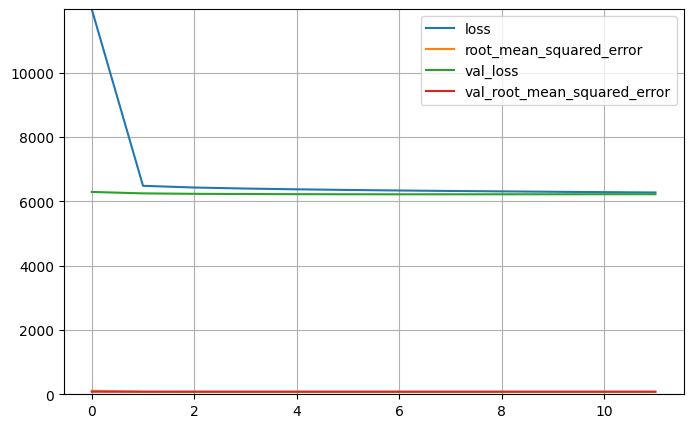

In [71]:
# Define/Compiling the Keras Model

tf.random.set_seed(42)

# Getting the number of features AFTER preprocessing
n_features_processed = X_train_processed.shape[1]

# Input Layer - shape needs to match the processed data...
input_layer = Input(shape=(n_features_processed,))

# Model
model = Sequential([
    input_layer,
    Dense(100, use_bias=False),   # Single Dense Layer w/ 100 Neurons
    BatchNormalization(),      # Batch Normalization after the 1st layer
    Activation("relu"),     # Now applying activation after Batch Normalization
    #Dropout(0.3),        # Commented out Dropout Rate...
    Dense(1)            # Single Neuron Output Layer (for Regression)
])

# Compiling the model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse",
              optimizer=optimizer,
              metrics=[RootMeanSquaredError()])


# Defining Callbacks & Training the Model

early_stopping = EarlyStopping(monitor='val_loss', # Monitoring validation loss
                              patience=5,    # Stop training if no improvement after 5 epochs
                              restore_best_weights=True) # Keep the best model weights found

history = model.fit(
    X_train_processed, # Processed training features
    y_train_np,        # Training targets
    epochs=100,
    validation_data=(X_val_processed, y_val_np), # Use processed validation features
    callbacks=[early_stopping],
    verbose=1
)

# Evaluating it's performance
val_loss, val_rmse = model.evaluate(X_val_processed, y_val_np, verbose=0)
print(f"\nValidation MSE (from evaluate): {val_loss:.4f}")
print(f"Validation RMSE (from evaluate): {val_rmse:.4f}")

# Ploting the learning curves
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, max(history.history['loss'] + history.history['val_loss']))
plt.show()

**Batch Normalization did NOT help...**

### Trial 5a - L2 (Ridge) Regularizaion

Epoch 1/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 15373.4697 - root_mean_squared_error: 122.0502 - val_loss: 6547.5454 - val_root_mean_squared_error: 80.8758
Epoch 2/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 6759.9502 - root_mean_squared_error: 82.1749 - val_loss: 6341.3823 - val_root_mean_squared_error: 79.5901
Epoch 3/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 6534.2295 - root_mean_squared_error: 80.7884 - val_loss: 6178.2339 - val_root_mean_squared_error: 78.5575
Epoch 4/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 6397.8271 - root_mean_squared_error: 79.9391 - val_loss: 6088.6812 - val_root_mean_squared_error: 77.9846
Epoch 5/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 6300.7031 - root_mean_squared_error: 79.3299 - val_loss: 6047.1396 - val_root_mean_squared_error: 77.7173
Epoch 6/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 6265.6074 - root_mean_squared_error: 79.1080 - val_loss: 6009.4907 - val_root_mean_squared

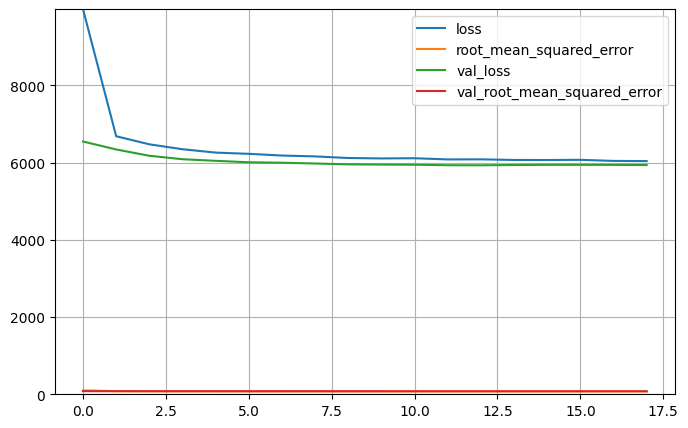

In [73]:
# Define/Compiling the Keras Model

tf.random.set_seed(42)

# Getting the number of features AFTER preprocessing
n_features_processed = X_train_processed.shape[1]

# Input Layer - shape needs to match the processed data...
input_layer = Input(shape=(n_features_processed,))

# Model
model = Sequential([
    input_layer,
    Dense(100, activation='relu',    # Single Dense Layer w/ 100 Neurons and ReLU Activation
          kernel_regularizer=regularizers.l2(0.01)),    # Added L2 Regularization (starting with 0.01)
    Dropout(0.3),        
    Dense(1)            # Single Neuron Output Layer (for Regression)
])

# Compiling the model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse",
              optimizer=optimizer,
              metrics=[RootMeanSquaredError()])


# Defining Callbacks & Training the Model

early_stopping = EarlyStopping(monitor='val_loss', # Monitoring validation loss
                              patience=5,    # Stop training if no improvement after 5 epochs
                              restore_best_weights=True) # Keep the best model weights found

history = model.fit(
    X_train_processed, # Processed training features
    y_train_np,        # Training targets
    epochs=100,
    validation_data=(X_val_processed, y_val_np), # Use processed validation features
    callbacks=[early_stopping],
    verbose=1
)

# Evaluating it's performance
val_loss, val_rmse = model.evaluate(X_val_processed, y_val_np, verbose=0)
print(f"\nValidation MSE (from evaluate): {val_loss:.4f}")
print(f"Validation RMSE (from evaluate): {val_rmse:.4f}")

# Ploting the learning curves
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, max(history.history['loss'] + history.history['val_loss']))
plt.show()

*L2 (Ridge) Regularization didn't help much, so we'll try L1 (Lasso) Next*

### Trial 5b - L1 (Lasso) Regularizaion

Epoch 1/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - loss: 15226.0449 - root_mean_squared_error: 121.4165 - val_loss: 6519.8608 - val_root_mean_squared_error: 80.7328
Epoch 2/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 6722.0254 - root_mean_squared_error: 81.9715 - val_loss: 6356.5767 - val_root_mean_squared_error: 79.7154
Epoch 3/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 6550.9131 - root_mean_squared_error: 80.9222 - val_loss: 6208.1836 - val_root_mean_squared_error: 78.7794
Epoch 4/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 6408.4492 - root_mean_squared_error: 80.0370 - val_loss: 6098.2656 - val_root_mean_squared_error: 78.0788
Epoch 5/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 6318.0142 - root_mean_squared_error: 79.4705 - val_loss: 6040.6157 - val_root_mean_squared_error: 77.7088
Epoch 6/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 6236.6211 - root_mean_squared_error: 78.9567 - val_loss: 5989.0972 - val_root_mean_squa

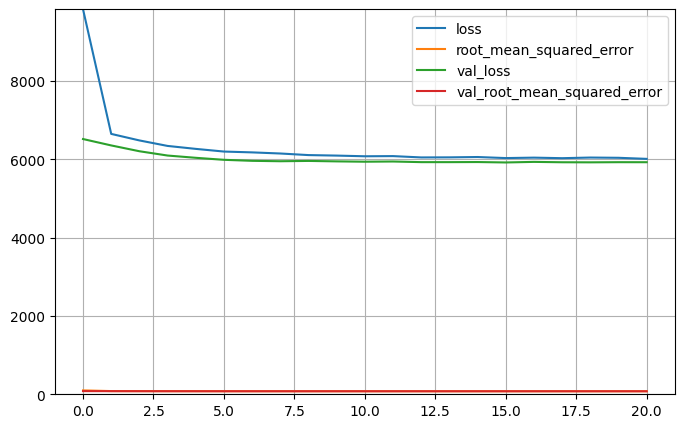

In [74]:
# Define/Compiling the Keras Model

tf.random.set_seed(42)

# Getting the number of features AFTER preprocessing
n_features_processed = X_train_processed.shape[1]

# Input Layer - shape needs to match the processed data...
input_layer = Input(shape=(n_features_processed,))

# Model
model = Sequential([
    input_layer,
    Dense(100, activation='relu',    # Single Dense Layer w/ 100 Neurons and ReLU Activation
          kernel_regularizer=regularizers.l1(0.001)),    # Added L2 Regularization (starting with 0.001)
    Dropout(0.3),        
    Dense(1)            # Single Neuron Output Layer (for Regression)
])

# Compiling the model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse",
              optimizer=optimizer,
              metrics=[RootMeanSquaredError()])


# Defining Callbacks & Training the Model

early_stopping = EarlyStopping(monitor='val_loss', # Monitoring validation loss
                              patience=5,    # Stop training if no improvement after 5 epochs
                              restore_best_weights=True) # Keep the best model weights found

history = model.fit(
    X_train_processed, # Processed training features
    y_train_np,        # Training targets
    epochs=100,
    validation_data=(X_val_processed, y_val_np), # Use processed validation features
    callbacks=[early_stopping],
    verbose=1
)

# Evaluating it's performance
val_loss, val_rmse = model.evaluate(X_val_processed, y_val_np, verbose=0)
print(f"\nValidation MSE (from evaluate): {val_loss:.4f}")
print(f"Validation RMSE (from evaluate): {val_rmse:.4f}")

# Ploting the learning curves
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, max(history.history['loss'] + history.history['val_loss']))
plt.show()

*L1 (Lasso) Regularization didn't help much either*

### Trial 6a - Batch Size = 16

**SPOILER:** This one ends up being the best, so I've changed the model object name to the_best_model to save this specific architecture and results

Epoch 1/100
3650/3650 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 12347.1924 - root_mean_squared_error: 109.1491 - val_loss: 6389.7031 - val_root_mean_squared_error: 79.9356
Epoch 2/100
3650/3650 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 6598.7397 - root_mean_squared_error: 81.2271 - val_loss: 6145.9810 - val_root_mean_squared_error: 78.3963
Epoch 3/100
3650/3650 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 6308.8594 - root_mean_squared_error: 79.4236 - val_loss: 6019.1113 - val_root_mean_squared_error: 77.5829
Epoch 4/100
3650/3650 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 6268.7896 - root_mean_squared_error: 79.1717 - val_loss: 5962.6372 - val_root_mean_squared_error: 77.2181
Epoch 5/100
3650/3650 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 6206.9399 - root_mean_squared_error: 78.7793 - val_loss: 5944.2827 - val_root_mean_squared_error: 77.0992
Epoch 6/100
3650/3650 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 6188.5010 - root_mean_squared_error: 78.6618 - val_loss: 5929.0781 - val_root_mean_squared

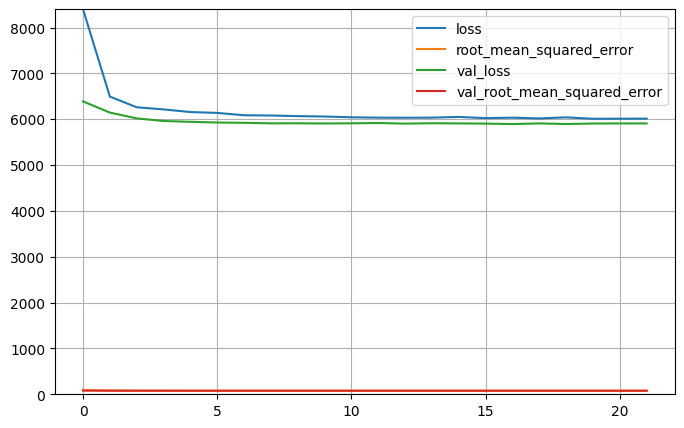

In [79]:
# Define/Compiling the Keras Model

tf.random.set_seed(42)

# Getting the number of features AFTER preprocessing
n_features_processed = X_train_processed.shape[1]

# Input Layer - shape needs to match the processed data...
input_layer = Input(shape=(n_features_processed,))

# Best Model so far...
the_best_model = Sequential([
    input_layer,
    Dense(100, activation="relu"),   # Single Dense Layer w/ 100 Neurons and ReLU activation
    Dropout(0.3),
    Dense(1)                        # Single Neuron Output Layer (for Regression)
])

# Compiling the model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
the_best_model.compile(loss="mse",
              optimizer=optimizer,
              metrics=[RootMeanSquaredError()])


# Defining Callbacks & Training the Model
early_stopping = EarlyStopping(monitor='val_loss', # Monitoring validation loss
                              patience=5,    # Stop training if no improvement after 5 epochs
                              restore_best_weights=True) # Keep the best model weights found

history = the_best_model.fit(
    X_train_processed, # Processed training features
    y_train_np,        # Training targets
    epochs=100,
    validation_data=(X_val_processed, y_val_np), # Use processed validation features
    callbacks=[early_stopping],
    batch_size=16,
    verbose=1
)

# Evaluating it's performance
val_loss, val_rmse = the_best_model.evaluate(X_val_processed, y_val_np, verbose=0)
print(f"\nValidation MSE (from evaluate): {val_loss:.4f}")
print(f"Validation RMSE (from evaluate): {val_rmse:.4f}")

# Ploting the learning curves
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, max(history.history['loss'] + history.history['val_loss']))
plt.show()

### Trial 6b - Batch Size = 64

Epoch 1/100
913/913 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 18725.8223 - root_mean_squared_error: 135.3724 - val_loss: 6969.1221 - val_root_mean_squared_error: 83.4813
Epoch 2/100
913/913 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 6979.9414 - root_mean_squared_error: 83.5420 - val_loss: 6510.3916 - val_root_mean_squared_error: 80.6870
Epoch 3/100
913/913 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 6692.0942 - root_mean_squared_error: 81.8016 - val_loss: 6381.2007 - val_root_mean_squared_error: 79.8824
Epoch 4/100
913/913 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 6544.8691 - root_mean_squared_error: 80.8979 - val_loss: 6261.2358 - val_root_mean_squared_error: 79.1280
Epoch 5/100
913/913 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 6428.7856 - root_mean_squared_error: 80.1772 - val_loss: 6184.8896 - val_root_mean_squared_error: 78.6441
Epoch 6/100
913/913 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 6368.8833 - root_mean_squared_error: 79.8032 - val_loss: 6148.0688 - val_root_mean_squared_error: 78.4

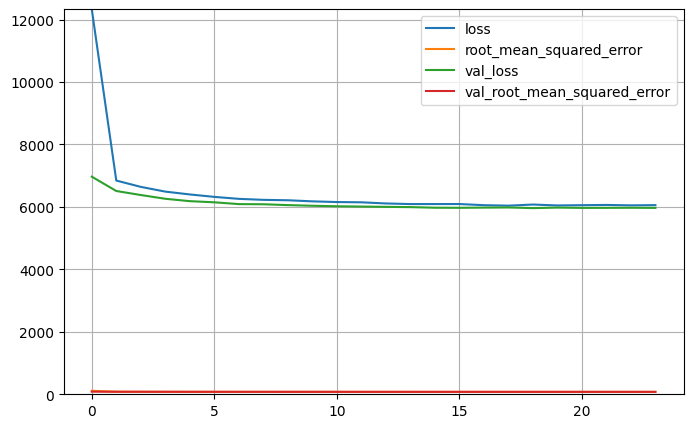

In [76]:
# Define/Compiling the Keras Model

tf.random.set_seed(42)

# Getting the number of features AFTER preprocessing
n_features_processed = X_train_processed.shape[1]

# Input Layer - shape needs to match the processed data...
input_layer = Input(shape=(n_features_processed,))

# Best Model so far...
model = Sequential([
    input_layer,
    Dense(100, activation="relu"),   # Single Dense Layer w/ 100 Neurons and ReLU activation
    Dropout(0.3),
    Dense(1)                        # Single Neuron Output Layer (for Regression)
])

# Compiling the model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse",
              optimizer=optimizer,
              metrics=[RootMeanSquaredError()])


# Defining Callbacks & Training the Model
early_stopping = EarlyStopping(monitor='val_loss', # Monitoring validation loss
                              patience=5,    # Stop training if no improvement after 5 epochs
                              restore_best_weights=True) # Keep the best model weights found

history = model.fit(
    X_train_processed, # Processed training features
    y_train_np,        # Training targets
    epochs=100,
    validation_data=(X_val_processed, y_val_np), # Use processed validation features
    callbacks=[early_stopping],
    batch_size=64,
    verbose=1
)

# Evaluating it's performance
val_loss, val_rmse = model.evaluate(X_val_processed, y_val_np, verbose=0)
print(f"\nValidation MSE (from evaluate): {val_loss:.4f}")
print(f"Validation RMSE (from evaluate): {val_rmse:.4f}")

# Ploting the learning curves
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, max(history.history['loss'] + history.history['val_loss']))
plt.show()

### Trial 6c - Batch Size = 128

Epoch 1/100
457/457 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 23907.6797 - root_mean_squared_error: 153.9795 - val_loss: 8829.6807 - val_root_mean_squared_error: 93.9664
Epoch 2/100
457/457 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 8465.9180 - root_mean_squared_error: 91.9965 - val_loss: 6925.8926 - val_root_mean_squared_error: 83.2219
Epoch 3/100
457/457 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7005.7993 - root_mean_squared_error: 83.6972 - val_loss: 6630.6133 - val_root_mean_squared_error: 81.4286
Epoch 4/100
457/457 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 6816.4634 - root_mean_squared_error: 82.5591 - val_loss: 6579.4126 - val_root_mean_squared_error: 81.1136
Epoch 5/100
457/457 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 6811.9170 - root_mean_squared_error: 82.5319 - val_loss: 6536.1748 - val_root_mean_squared_error: 80.8466
Epoch 6/100
457/457 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6711.9624 - root_mean_squared_error: 81.9234 - val_loss: 6461.1587 - val_root_mean_squared_error: 80.3

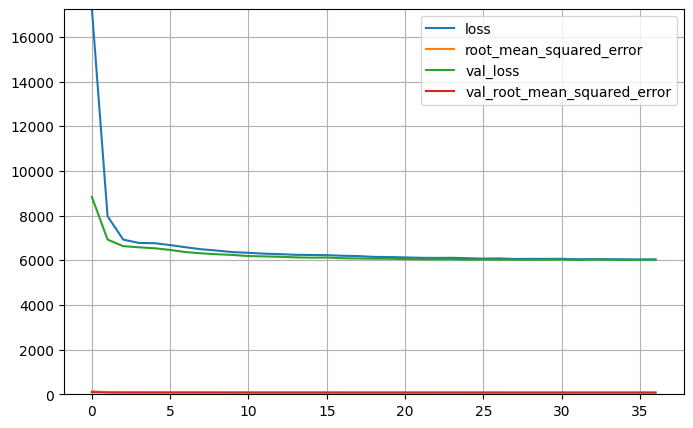

In [77]:
# Define/Compiling the Keras Model

tf.random.set_seed(42)

# Getting the number of features AFTER preprocessing
n_features_processed = X_train_processed.shape[1]

# Input Layer - shape needs to match the processed data...
input_layer = Input(shape=(n_features_processed,))

# Best Model so far...
model = Sequential([
    input_layer,
    Dense(100, activation="relu"),   # Single Dense Layer w/ 100 Neurons and ReLU activation
    Dropout(0.3),
    Dense(1)                        # Single Neuron Output Layer (for Regression)
])

# Compiling the model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse",
              optimizer=optimizer,
              metrics=[RootMeanSquaredError()])


# Defining Callbacks & Training the Model
early_stopping = EarlyStopping(monitor='val_loss', # Monitoring validation loss
                              patience=5,    # Stop training if no improvement after 5 epochs
                              restore_best_weights=True) # Keep the best model weights found

history = model.fit(
    X_train_processed, # Processed training features
    y_train_np,        # Training targets
    epochs=100,
    validation_data=(X_val_processed, y_val_np), # Use processed validation features
    callbacks=[early_stopping],
    batch_size=128,
    verbose=1
)

# Evaluating it's performance
val_loss, val_rmse = model.evaluate(X_val_processed, y_val_np, verbose=0)
print(f"\nValidation MSE (from evaluate): {val_loss:.4f}")
print(f"Validation RMSE (from evaluate): {val_rmse:.4f}")

# Ploting the learning curves
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, max(history.history['loss'] + history.history['val_loss']))
plt.show()

##### We FINALLY got a small improvement by making Batch Size = 16 instead of the default 32...

*So the BEST Neural Network Configuration I've found is:*

**Architecture: Input -> Dense(100, activation='relu') -> Dropout(0.3) -> Dense(1)**

**Optimizer: Adam(learning_rate=1e-3)**

***Training Batch Size: 16***

In [83]:
print("Evaluating the final best Neural Network Configuration on the TEST set...")
test_loss_final, test_rmse_final = the_best_model.evaluate(X_test_processed, y_test_np, verbose=0)

print(f"\nFinal NN Model - TEST Set Performance:")
print(f"Test MSE: {test_loss_final:.4f}")
print(f"Test RMSE: {test_rmse_final:.4f}")

Evaluating the final best Neural Network Configuration on the TEST set...

Final NN Model - TEST Set Performance:
Test MSE: 6048.3774
Test RMSE: 77.7713


## That's it! Unfortunately after all that work, the result isn't much better than the Random Forests I trained earlier... so it seem's we've hit a performance plateau/wall with trying to model this dataset...

#### *But are these results acceptable?*

In [82]:
print(y_train.describe())

count    58400.000000
mean       136.398116
std        108.884855
min          0.000000
25%         48.000000
50%        107.000000
75%        202.000000
max        496.000000
Name: Units Sold, dtype: float64


## *Analysis of Acceptability:*
*(Both full models (Notebooks 1 and 5) were almost identical in RME and RMSE, so this analysis is for both of them)*

#### RMSE vs. Mean/Median:

- The average daily sales (mean) is ~136 units.
- The median daily sales (50%) is 107 units (meaning half the time, sales are 107 units or less).

The model's average error (RMSE) is ~77.8 units.
- Relative Error (vs. Mean): 77.8 / 136.4 = 0.57 or ~57%.
- Relative Error (vs. Median): 77.8 / 107.0 = 0.73 or ~73%.


...This is pretty high. **This models average prediction error is more than half the value of the average daily sales.**

#### RMSE vs. Standard Deviation:

- The standard deviation is ~109 units. ***That is quite a significant spread in daily sales numbers...***
- The model's RMSE (77.8) is smaller than the standard deviation... 

**This is good, because it confirms the model is learning something and *performs better than just predicting the average sales every day.***

...however, the RMSE is still about ~71% of the standard deviation... which suggests ***a large portion of the variability in sales is unfortunately NOT being captured by the model :/***

#### RMSE vs. Interquartile Range (IQR):

- The IQR (spread of the middle 50% of daily sales) is 202 - 48 = 154 units.
- The RMSE is about ~50% of the IQR.

...So, the **average error** of the model is **roughly half the typical range** seen in the bulk of the 2 year timespan of this data.

## Conclusion:

**A Test RMSE of ~77.8, for this data, appears VERY high and is likely NOT acceptable for practical Supply Chain/Operations/Inventory management purposes... :/**

- The *error is a VERY large percentage of the mean/median* sales values.
- While **better than guessing** the average (compared to the standard deviation and IQR), it *still represents a large amount of unexplained variance.*

**An average error this large could lead to significant inaccuracies in ordering, potentially causing frequent overstocking or stockouts, depending on how the forecast is used...**
#### **So I'd reccomend using either of these models as sort of a "compass", to point you (the Inventory Manager) in "a" direction, but then using your intuition and gut to make your real guess.**